## MSF from CRSP via WRDS
- msf: Monthly Stock File
- Link for CRSP at WRDS: https://wrds-www.wharton.upenn.edu/pages/about/data-vendors/center-for-research-in-security-prices-crsp/
- Link for MSF at WRDS: https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/stock-security-files/monthly-stock-file/
- Link for variable definitions in MSF: https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/stock-security-files/monthly-stock-file/
- Info for identifiers (Stanford): https://libguides.stanford.edu/c.php?g=559845&p=6686228

-------------------------

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wrds
pd.set_option('display.max_columns', None)

### Connect WRDS

In [2]:
conn=wrds.Connection()

Enter your WRDS username [yjaey]: yjaeyoon
Enter your password: ···············


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


Created .pgpass file successfully.
Loading library list...
Done


### Check variables in msf

In [3]:
conn.describe_table(library='crsp', table='msf')

Approximately 4834507 rows in crsp.msf.


,name,nullable,type
0,cusip,True,VARCHAR(8)
1,permno,True,DOUBLE_PRECISION
2,permco,True,DOUBLE_PRECISION
3,issuno,True,DOUBLE_PRECISION
4,hexcd,True,DOUBLE_PRECISION
5,hsiccd,True,DOUBLE_PRECISION
6,date,True,DATE
7,bidlo,True,DOUBLE_PRECISION
8,askhi,True,DOUBLE_PRECISION
9,prc,True,DOUBLE_PRECISION


<b>Variables</b>:  
- <b>permco</b>: CRSP Permanent Company Number 
- <b>permno</b>: CRSP Permanent Stock (Share Class) Number 
- <b>ret</b>: Holding Period Return (ret)
- <b>vol</b>: The sum of the trading volumes during that month (in 100 shares).
- <b>shrout</b>: The number of shares outstanding in thousands

------------

### Get data

In [4]:
conn.get_row_count(library='crsp', table='msf')

4834507

### Download msf data

In [5]:
df= conn.get_table(library='crsp', table='msf', obs= 5)
print(df.shape)
df.head(5)

(5, 21)


,cusip,permno,permco,issuno,hexcd,hsiccd,date,bidlo,askhi,prc,vol,ret,bid,ask,shrout,cfacpr,cfacshr,altprc,spread,altprcdt,retx
0,68391610,10000.0,7952.0,10396.0,3.0,3990.0,1985-12-31,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,-2.5625,NaN,1986-01-07,NaN
1,68391610,10000.0,7952.0,10396.0,3.0,3990.0,1986-01-31,-2.50,-4.4375,-4.3750,1771.0,NaN,None,None,3680.0,1.0,1.0,-4.3750,0.250,1986-01-31,NaN
2,68391610,10000.0,7952.0,10396.0,3.0,3990.0,1986-02-28,-3.25,-4.3750,-3.2500,828.0,-0.257143,None,None,3680.0,1.0,1.0,-3.2500,0.250,1986-02-28,-0.257143
3,68391610,10000.0,7952.0,10396.0,3.0,3990.0,1986-03-31,-3.25,-4.4375,-4.4375,1078.0,0.365385,None,None,3680.0,1.0,1.0,-4.4375,0.125,1986-03-31,0.365385
4,68391610,10000.0,7952.0,10396.0,3.0,3990.0,1986-04-30,-4.00,-4.3125,-4.0000,957.0,-0.098592,None,None,3793.0,1.0,1.0,-4.0000,0.250,1986-04-30,-0.098592


In [6]:
df_2020= conn.raw_sql(sql= f"""select cusip, permno, permco, issuno, hexcd, hsiccd, date, prc, vol, ret, shrout
                    from crsp.msf
                    where date >= '2020-01-01' and date <= '2020-12-31' """)

In [7]:
print(df_2020.shape)
df_2020.head(2)

(93741, 11)


,cusip,permno,permco,issuno,hexcd,hsiccd,date,prc,vol,ret,shrout
0,46603210,10026.0,7976.0,10433.0,3.0,2052.0,2020-01-31,165.839996,22433.0,-0.100016,18919.0
1,29402E10,10028.0,7978.0,22226.0,2.0,5094.0,2020-01-31,2.170000,27373.0,0.607407,26924.0


### Exlude fin and reg industries

In [8]:
df_2020['fin']= ((df_2020.hsiccd>=6000) & (df_2020.hsiccd<7000)).astype(int)
df_2020['reg1']= ((df_2020.hsiccd>=4900) & (df_2020.hsiccd<5000)).astype(int)
df_2020['reg2']= ((df_2020.hsiccd>=4400) & (df_2020.hsiccd<5000)).astype(int)
df_2020['mv']= df_2020['prc']*df_2020['shrout']/10**3 # market cap in millions (as shrout is already in thousands)
df_2020.head(2)

,cusip,permno,permco,issuno,hexcd,hsiccd,date,prc,vol,ret,shrout,fin,reg1,reg2,mv
0,46603210,10026.0,7976.0,10433.0,3.0,2052.0,2020-01-31,165.839996,22433.0,-0.100016,18919.0,0,0,0,3137.526891
1,29402E10,10028.0,7978.0,22226.0,2.0,5094.0,2020-01-31,2.170000,27373.0,0.607407,26924.0,0,0,0,58.425082


In [9]:
df_2020[['fin', 'reg1', 'reg2', 'mv']].mean()

fin        0.469133
reg1       0.015543
reg2       0.041817
mv      5577.794099
dtype: float64

In [10]:
df_2020= df_2020[(df_2020.fin==0)]
df_2020= df_2020[(df_2020.reg1==0)]
print(df_2020.shape)
df_2020.head(2)

(48307, 15)


,cusip,permno,permco,issuno,hexcd,hsiccd,date,prc,vol,ret,shrout,fin,reg1,reg2,mv
0,46603210,10026.0,7976.0,10433.0,3.0,2052.0,2020-01-31,165.839996,22433.0,-0.100016,18919.0,0,0,0,3137.526891
1,29402E10,10028.0,7978.0,22226.0,2.0,5094.0,2020-01-31,2.170000,27373.0,0.607407,26924.0,0,0,0,58.425082


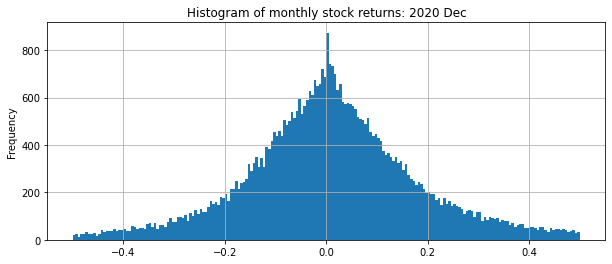

In [11]:
df_2020[df_2020['ret'].abs()<=0.5]['ret'].plot(kind='hist', 
                                                             bins=200, 
                                                             figsize=(10,4), 
                                                             grid= True, 
                                                             title= "Histogram of monthly stock returns: 2020 Dec")
plt.show()

In [12]:
dist= df_2020.groupby('date').size()
dist_min= dist.min()
dist_max= dist.max()

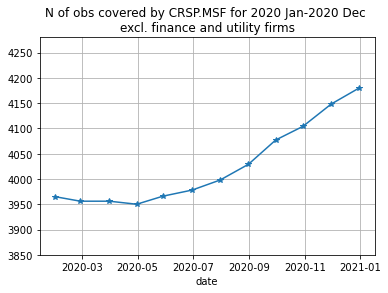

In [21]:
dist.plot(kind='line', marker='*', grid= True)
plt.ylim([dist_min-100,dist_max+100])
plt.title("N of obs covered by CRSP.MSF for 2020 Jan-2020 Dec \nexcl. finance and utility firms")
plt.show()

---------

### Close connection

In [14]:
conn.close()

---------